## 1. RetinaFlow on one example

In [1]:
import cv2
import numpy as np
from retina.detector import *
from utils.video import * 
from utils.image import * 
from utils.optical import *
import os

/anaconda/envs/py35/lib/python3.5/site-packages/h5py/__init__.py:36: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  from ._conv import register_converters as _register_converters
Using TensorFlow backend.


In [2]:
retina_path = os.path.join('../video-indexing-poc', 'models', 'resnet50_csv_24_0.93-inference.h5')
retina = RetinaNet(retina_path)
print("----- Retina loaded -----")
video = video_to_npy('videos/collisions/output122.mp4', width=480)
print("----- Video loaded -----")
boxes = [retina.predict(frame) for frame in video] 
print("----- Detection finished -----")

/anaconda/envs/py35/lib/python3.5/site-packages/keras/models.py:255: UserWarning: No training configuration found in save file: the model was *not* compiled. Compile it manually.
  warnings.warn('No training configuration found in save file: '


----- Retina loaded -----
reading fresh video from videos/collisions/output122.mp4
----- Video loaded -----
----- Detection finished -----


In [3]:
# params for ShiTomasi corner detection
feature_params = dict(
    maxCorners = 100,
    qualityLevel = 0.3,
    minDistance = 7,
    blockSize = 7
)
# Parameters for lucas kanade optical flow
lk_params = dict( 
    winSize  = (15,15),
    maxLevel = 2,
    criteria = (cv2.TERM_CRITERIA_EPS | cv2.TERM_CRITERIA_COUNT, 10, 0.03)
)
    
flow = RetinaFlow(feature_params, lk_params)

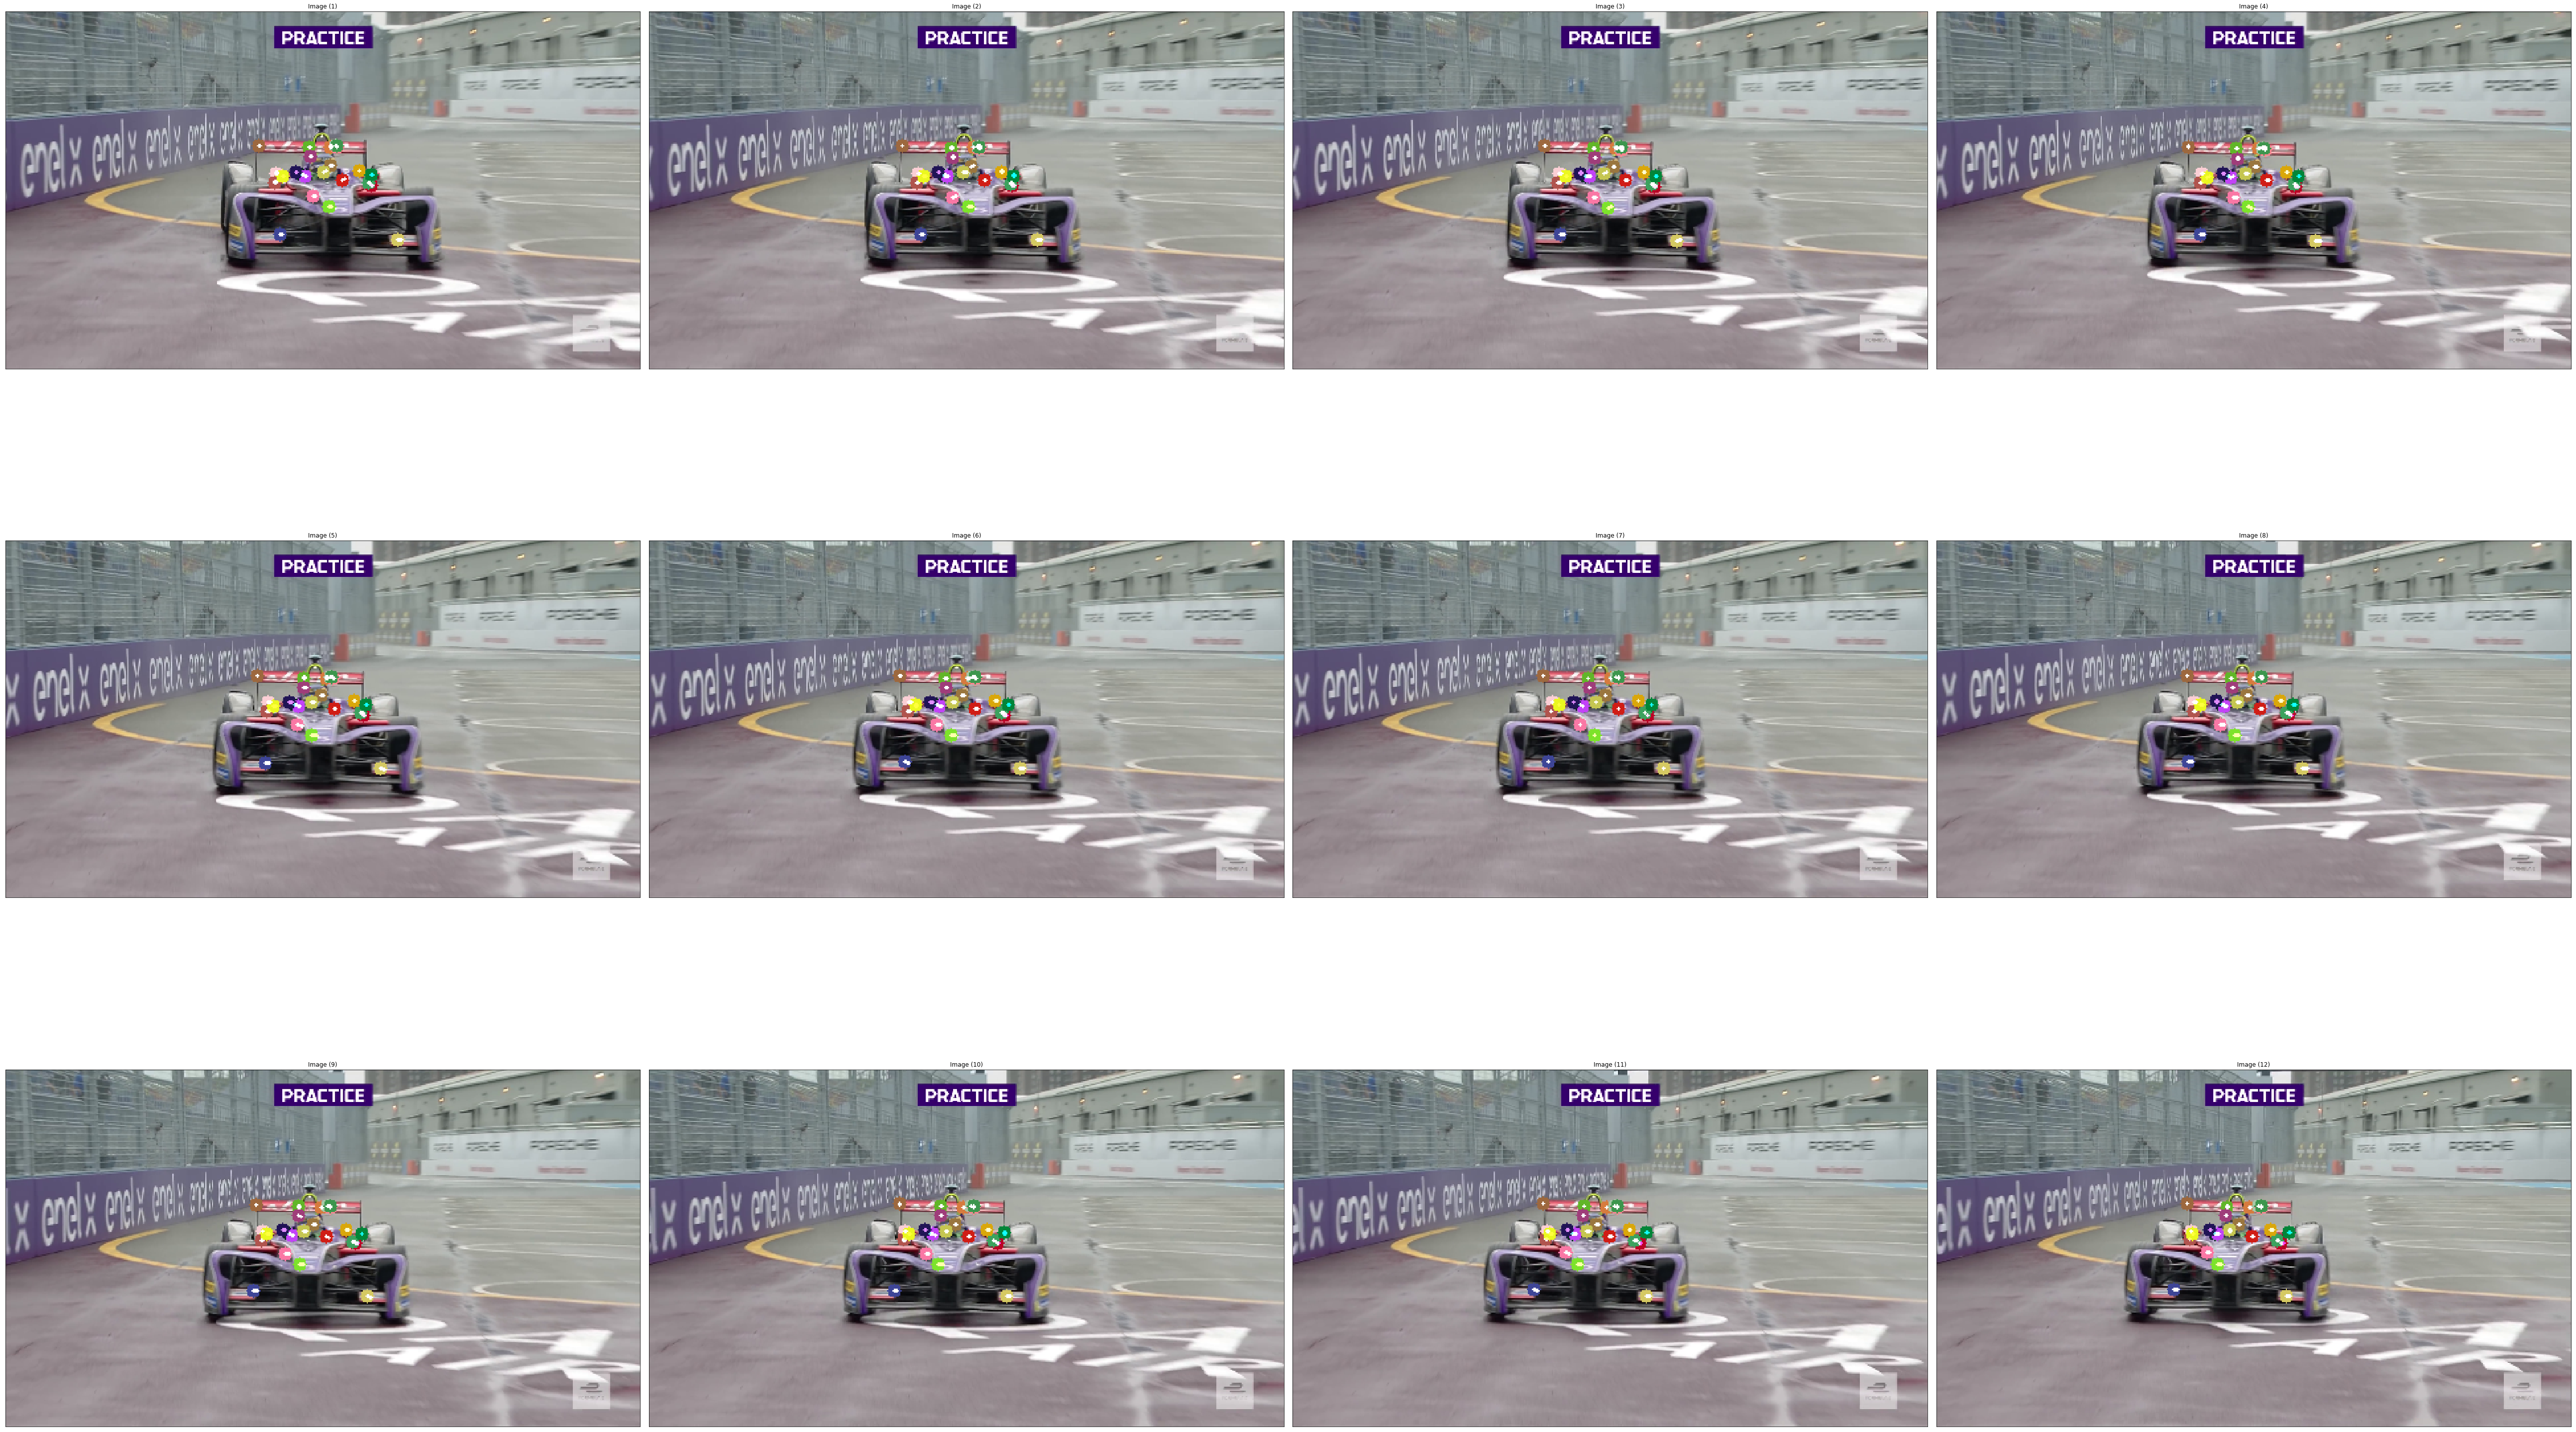

In [4]:
video_draw = flow.draw(video, boxes, (0.2, 0))
video_grad = flow.get_gradients(video, boxes, (0.2, 0))
show_images(video_draw[-12:], 3)

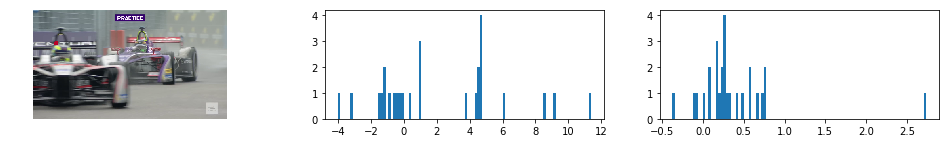

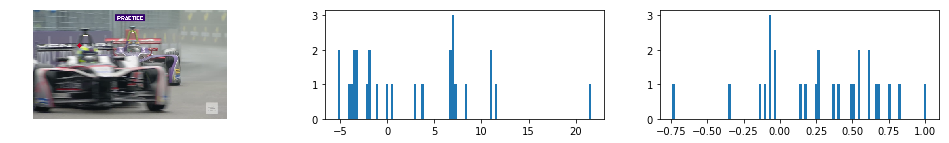

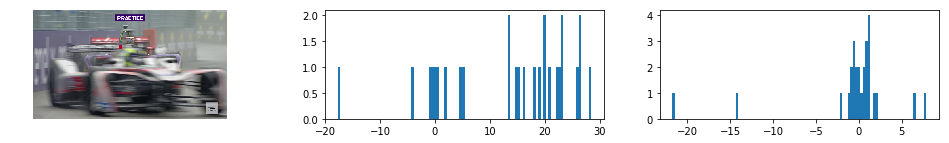

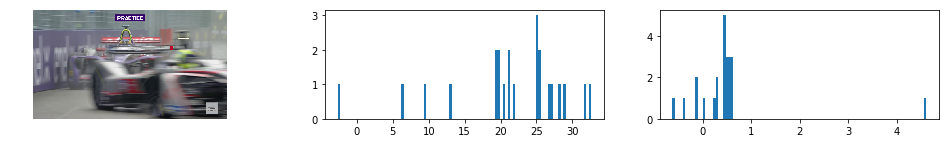

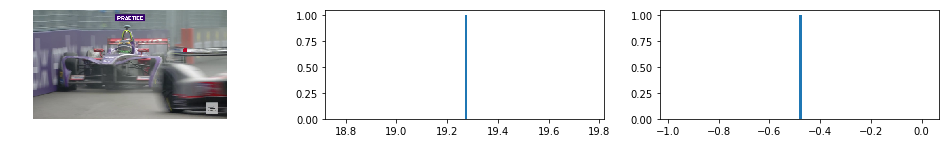

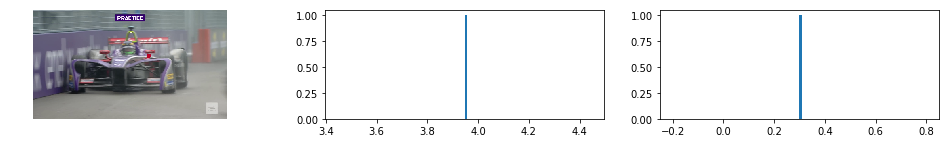

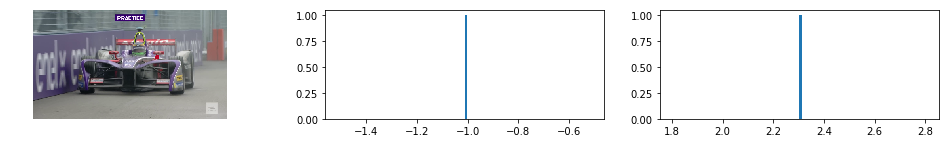

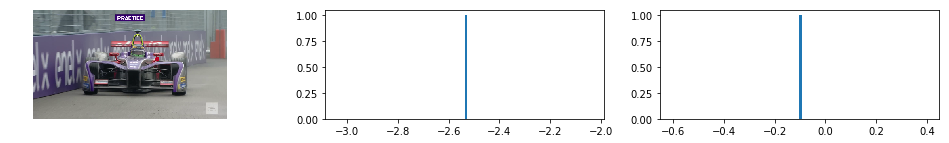

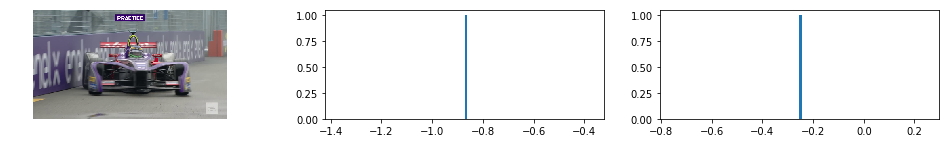

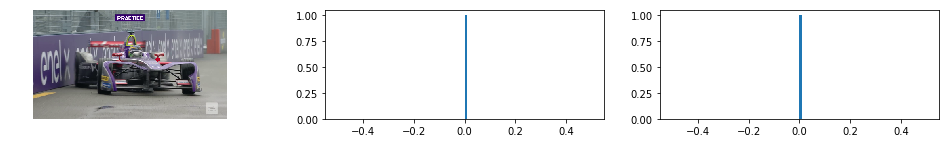

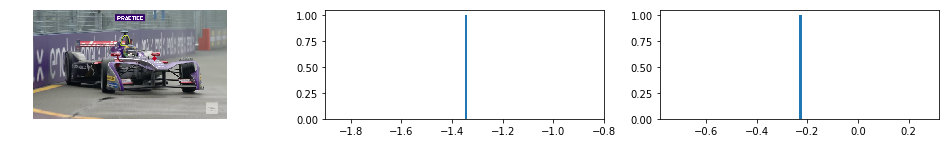

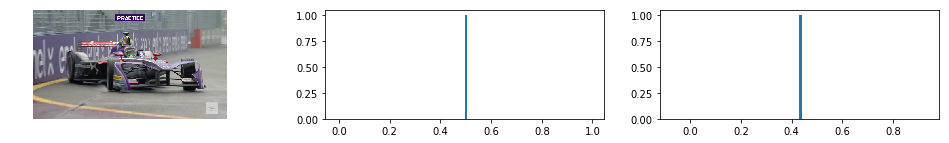

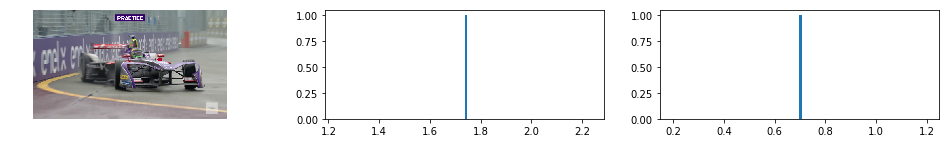

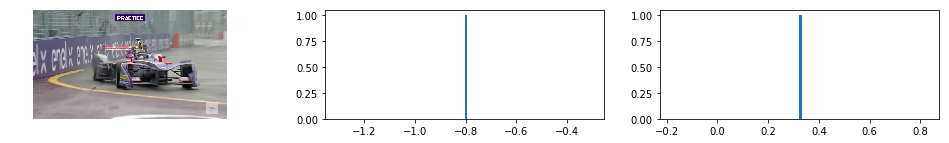

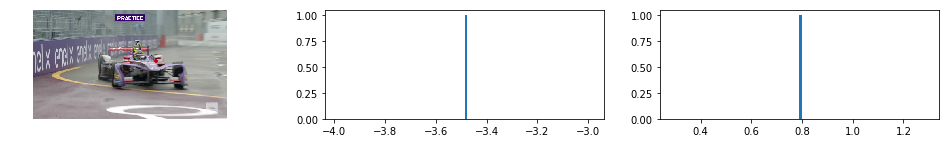

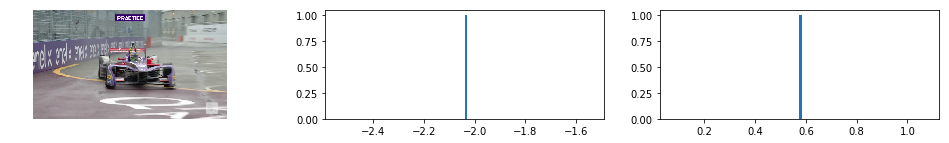

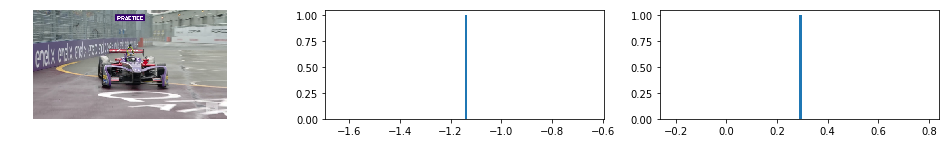

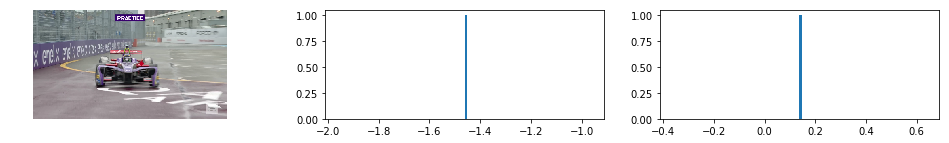

In [5]:
for i in range(0, len(video) - 1, 7):
    fig = plt.figure(figsize=(17,2))

    plt.subplot(1, 3, 1)
    plt.imshow(video[i + 1])
    plt.axis('off')

    plt.subplot(1, 3, 2)
    plt.hist(video_grad[i][0], bins=100)

    plt.subplot(1, 3, 3)
    plt.hist(video_grad[i][1], bins=100)

plt.show()

## 2. Gradient histograms for two classes

In [6]:
from os import listdir
from os.path import isfile, join
from pipe import *
import pickle
from itertools import *


def GetVideos( path, label, ext='.mp4' ):
    p = listdir(path) | where( lambda p: p.endswith(ext) ) | as_list()
    return zip( repeat(label, len(p)), map( lambda p: join( path, p ), p ) )
    
    
def save_flows(path, retina, flow):
    collisions = GetVideos(path, 0, '.mp4') 
    for _, filename in collisions:
        pickle_name = filename + '.pickle'
        if not isfile(pickle_name):
            video = video_to_npy(filename, fps=25, width=480)
            boxes = [retina.predict(frame) for frame in video] 
            flw = flow.run(video, boxes, (0.2, 0))
            pickle.dump(flw, open(pickle_name, "wb")) 
    
collisions_path = 'videos/collisions'
non_collisions_path = 'videos/not-collisions'
    
save_flows(collisions_path, retina, flow)
save_flows(non_collisions_path, retina, flow)

### 2.1 Collisions report

In [7]:
%matplotlib inline

def to_polar(video):
    return [np.array(cv2.cartToPolar(frame[0], frame[1])).squeeze(axis=2) for frame in video]

def calc_gradients(flow):
    def calc(flowi):
        old, new = zip(*flowi)
        return (np.array(new) - np.array(old)).T
    return [calc(flowi) for flowi in flow if flowi]

def display_report(path):
    data = ( 
        GetVideos(path, 1, '.opt') 
            | select(lambda x: pickle.load(open(x[1], 'rb'))) 
            | select(lambda x: calc_gradients(x))
            | as_list
        )
    polar = (
        data.copy() 
            | select(lambda x: to_polar(x)) 
            | aggregate(lambda x, y: x + y)
            | as_list
    )
    data = data | aggregate(lambda x, y: x + y)
    
    x_grads = data | select(lambda x: x[0]) | aggregate(lambda x, y: np.concatenate([x, y]))
    y_grads = data | select(lambda x: x[1]) | aggregate(lambda x, y: np.concatenate([x, y]))
    
    angle = polar | select(lambda x: x[0]) | aggregate(lambda x, y: np.concatenate([x, y])) 
    magnitude = polar | select(lambda x: x[1]) | aggregate(lambda x, y: np.concatenate([x, y])) 
    
    print("X min =", np.min(x_grads))
    print("X max =", np.max(x_grads))
    print("Y min =", np.min(y_grads))
    print("Y max =", np.max(y_grads))
    
    fig = plt.figure(figsize=(17,14))
    plt.subplot(4, 1, 1)
    plt.hist(x_grads, bins=100, normed=True)
    plt.title("X gradients")

    plt.subplot(4, 1, 2)
    plt.hist(y_grads, bins=100, normed=True)
    plt.title("Y gradients")
    
    plt.subplot(4, 1, 3)
    plt.hist(angle, bins=100, normed=True)
    plt.title("Angle")
    
    plt.subplot(4, 1, 4)
    plt.hist(magnitude, bins=100, normed=True)
    plt.title("Magnitude")
    
    plt.show()
    
    return x_grads, y_grads, angle, magnitude

X min = -362.93433
X max = 410.22723
Y min = -224.51283
Y max = 199.90118


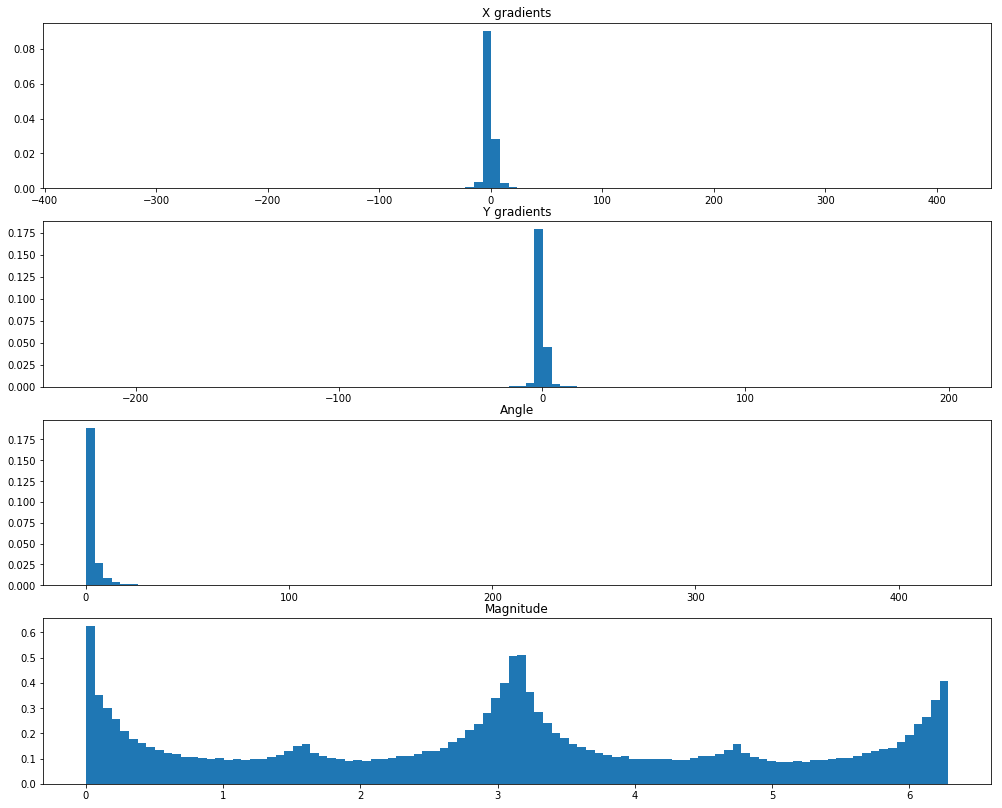

In [8]:
col_x, col_y, col_a, col_m = display_report(collisions_path)

### 2.2 Non collisions report

X min = -311.35516
X max = 374.00177
Y min = -213.06503
Y max = 151.60524


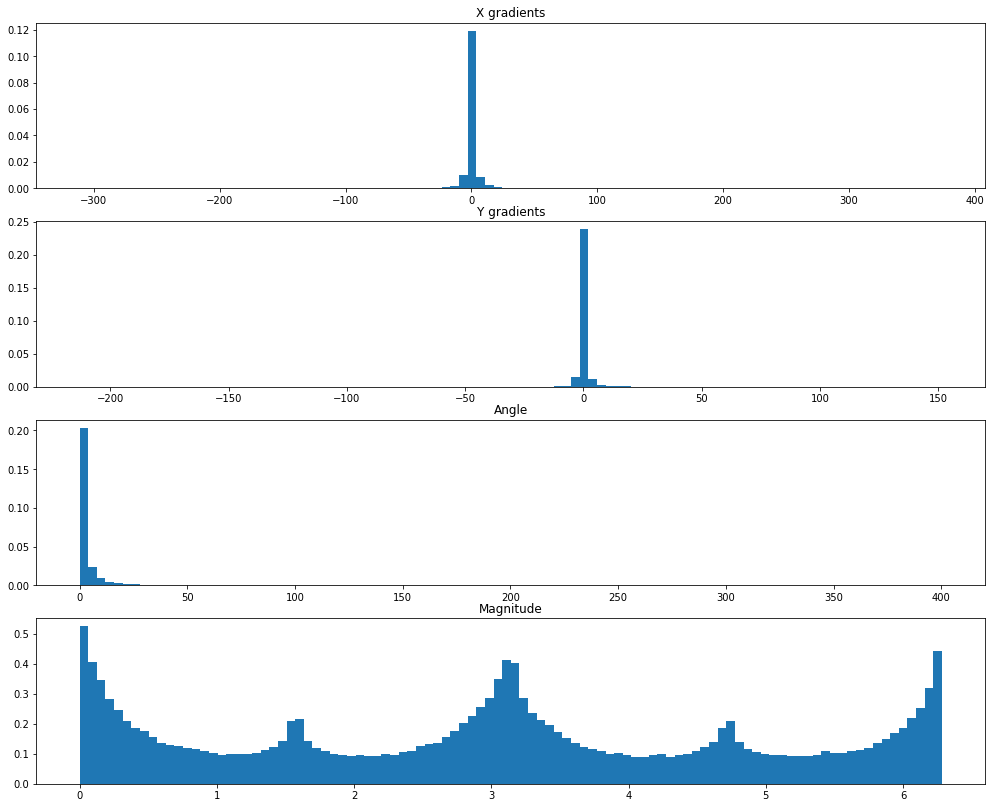

In [9]:
ncol_x, ncol_y, ncol_a, ncol_m = display_report(non_collisions_path)

### 2.3 Collisions vs. Non collisions

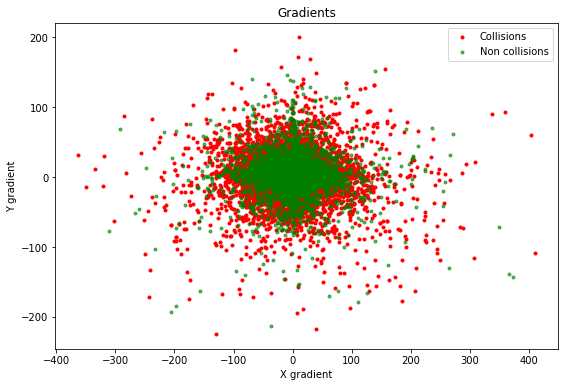

In [10]:
plt.figure(figsize=(9, 6))
cols_scatter = plt.scatter(col_x, col_y, c='r', marker='.')
ncols_scatter = plt.scatter(ncol_x, ncol_y, c='g', alpha=0.6, marker='.')
plt.title('Gradients')
plt.xlabel('X gradient')
plt.ylabel('Y gradient')
plt.legend([cols_scatter, ncols_scatter], ['Collisions', 'Non collisions']);

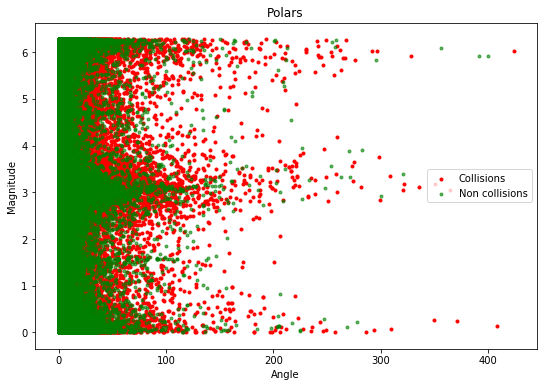

In [11]:
plt.figure(figsize=(9, 6))
cols_scatter = plt.scatter(col_a, col_m, c='r', marker='.')
ncols_scatter = plt.scatter(ncol_a, ncol_m, c='g', alpha=0.6, marker='.')
plt.title('Polars')
plt.xlabel('Angle')
plt.ylabel('Magnitude')
plt.legend([cols_scatter, ncols_scatter], ['Collisions', 'Non collisions']);

### 2.4 MAD (mean absolute deviation) calculation 

In [12]:
def mad(data):
    return np.mean(np.absolute(data - np.mean(data)))


def calculate_mad(path):
    data = ( 
        GetVideos(path, 1, '.opt') 
            | select(lambda x: pickle.load(open(x[1], 'rb'))) 
            | select(lambda x: calc_gradients(x))
            | select(lambda x: list(map(lambda y: y[0], x)))
            | where(lambda x: x)
            | select(lambda x: mad(np.concatenate(x)))
            | as_list
        )
    return data

In [13]:
mad_collisions = calculate_mad(collisions_path)
mad_non_collisions = calculate_mad(non_collisions_path)

In [14]:
mads = np.concatenate([mad_collisions, mad_non_collisions])
labels = np.concatenate([np.repeat(1, len(mad_collisions)), np.repeat(0, len(mad_non_collisions))])
np.corrcoef(mads, labels)

array([[1.        , 0.00192392],
       [0.00192392, 1.        ]])